## Power-Seek algorithm


In [1]:
#call libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt  
import os
import sys

In [2]:
PATH = os.path.expanduser('~') + '/Dropbox/suvranil/cellmem'

#### Parameters

In [3]:
ng = int(512)   # number of genes in gene network
alpha = 2.0      # alpha is shape parameter
beta = 2.0       # bete is inverse scale parameter
muall = np.loadtxt(PATH +'/data' + '/gene_16384.txt')
mu = muall[: ng]
print('Mean of Mus: ', np.round(-np.mean(mu), 2))
amp = 0.1        # noise amplitude


#parameters for cell lineage 
iter = 100       # number of realizations for ensemble average 
t_c = 0.5        # cell division time
b = 11           # number of branch
nc = 2**(b - 1)
#comment : If we run code for b = 8, we will get max 2**7 cell in the final branch. 


Mean of Mus:  1.04


#### Importing single timepoint scRNA data matrix

In [4]:
m = np.load(PATH +
            '/data/20241212/' + 
            'gene_{}_cell_{}_divtime_{}_amp_{}_trial_{}.npy'.format(ng, 
                                                                    2**(b - 1), 
                                                                    t_c, amp, iter), 
                                                                    allow_pickle = True)
m = m.astype('float32')
print('shape of m: ', m.shape)
eff_iter = 1 #number of realizations we'll use

shape of m:  (100, 1024, 512)


#### 

#### Calculating threshold number of eigenvalues (n)

In [5]:
#single timepoint scRNA-seq data matrix
z = m[0]
#updated data matrix
X_S = (z - np.mean(z, axis = 0))/ np.std(z, axis = 0)
cv = np.matmul(X_S, X_S.T) / ng
ev = np.linalg.eigvalsh(cv)[::-1]
rank = np.linspace(1, nc, nc)

r-squared val is:  0.99


Text(0, 0.5, 'Eigenvalues')

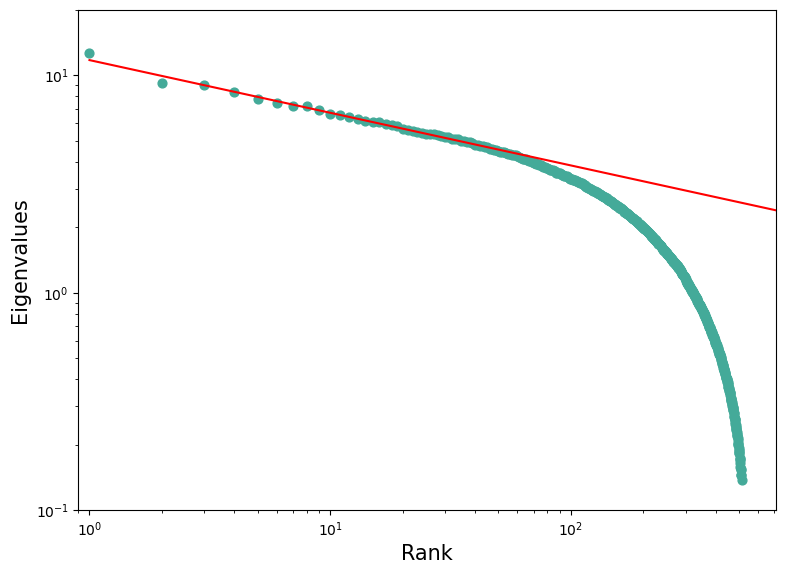

In [6]:
threshold = 25  #vary this threhold for desired R^2 value
x_data = np.log(rank[: threshold])
y_data = np.log(ev[: threshold])
# fitting using linear regression
result = stats.linregress(x_data, y_data)
slope, intercept, r_val = result[0], result[1], result[2]
print('r-squared val is: ', np.round(r_val**2, 2))

# fitting data
x_fit_data = np.linspace(np.log(1), 10, 10)
y_fit_data = slope * x_fit_data + intercept

# for plotting in a log-log graph
exp_x_fit_data = np.exp(x_fit_data)
exp_y_fit_data = np.exp(y_fit_data)

f = plt.figure(figsize=(9, 6.5), dpi = 100)
ax = f.add_subplot()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10**-1, 20)
ax.set_xlim(0.9, ng + 200)
ax.scatter(rank, ev,s = 40, color = '#44aa99', linewidth = 1.0)
ax.plot(exp_x_fit_data, exp_y_fit_data, c = 'red')
ax.set_xlabel('Rank',fontsize=15)
ax.set_ylabel('Eigenvalues',fontsize=15)

#### Implementation of Power-Seq algorithm

In [7]:
gene_box = []
for gene in range (0, ng, 1):
    delta_box = []
    for i in range (0, eff_iter, 1):
        z = m[i] #i-th realization of single timepoint scRNA data matrix
        #data matrix normalization and centralization
        X_S = (z - np.mean(z, axis = 0)) / np.std(z, axis = 0)
        cv = np.matmul(X_S, X_S.T) / ng
        EV = np.flip(np.linalg.eigvalsh(cv))
        
        #update data matrix
        X_S1 = np.delete(X_S, obj = gene, axis = 1)
        cv1 = np.matmul(X_S1, X_S1.T) / (ng - 1)
        EV1 = np.flip(np.linalg.eigvalsh(cv1))

        #calculating change in eigenspectra
        delta = np.sum(EV[: threshold] - EV1[: threshold])
        delta_box.append(delta)
    # storing delta_g for each realizations of a gene 'g'
    gene_box.append(np.array(delta_box))  
    print(gene)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
# Caculating ensemble averaged delta_g
delta_box = np.array(gene_box)
mean_sod = np.mean(delta_box, axis = 1)
std_sod = np.std(delta_box, axis = 1)
order = np.argsort(-mean_sod)
x = mu[order]
HalfLife = np.log(2) / (2 * x * 0.5)
y = mean_sod[order]
err = std_sod[order]

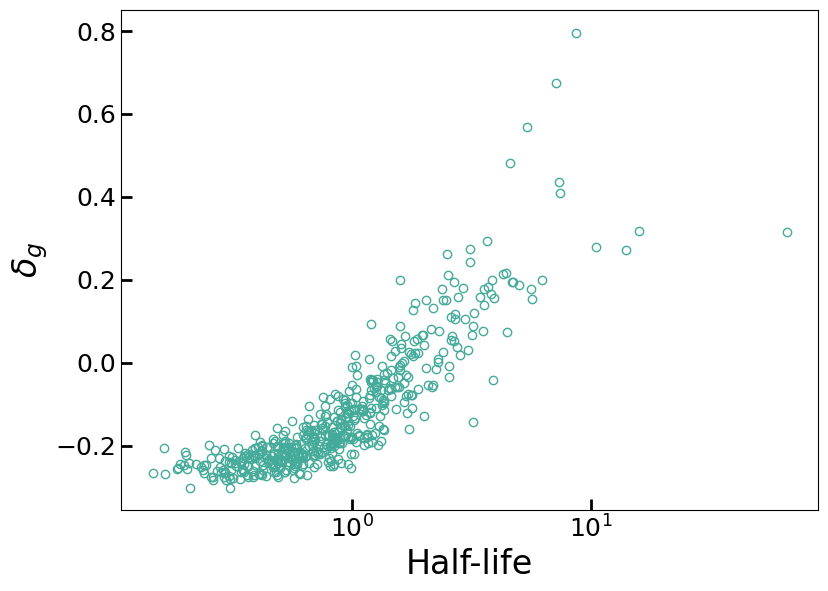

In [12]:
f = plt.figure(figsize=(9, 6.5), dpi = 100)
ax = f.add_subplot()
ax.set_xscale('log')
ax.errorbar(-HalfLife, y, yerr= err, fmt='o', mfc='none',
         mec='#44aa99', ecolor='#cc6677', lw = 1.0)
ax.set_xlabel('Half-life',fontsize=24)
ax.set_ylabel(r'$\delta_g$',fontsize=24)
ax.tick_params(axis='y',labelsize=18, width = 3)
ax.tick_params(axis='x',labelsize=18, width = 3)
ax.tick_params(which="minor", length = 0)
ax.tick_params(which="major", direction='in', length = 8, 
               width = 2)

Cheers!!